## Step 0: Initialize model

In [15]:
import torch
from transformers import AutoImageProcessor, AutoModelForSemanticSegmentation
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image

In [3]:
# Load the pre-trained SegFormer-B5 model and image processor
model_id = "nvidia/segformer-b5-finetuned-cityscapes-1024-1024"
processor = AutoImageProcessor.from_pretrained(model_id)
model = AutoModelForSemanticSegmentation.from_pretrained(model_id)

preprocessor_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/339M [00:00<?, ?B/s]

In [46]:
# Visualization function (not for demonstration)
# 1. Cityscapes categories
CITYSCAPES_CLASSES = [
    "road", "sidewalk", "building", "wall", "fence", "pole", "traffic light", 
    "traffic sign", "vegetation", "terrain", "sky", "person", "rider", 
    "car", "truck", "bus", "train", "motorcycle", "bicycle"
]

# 2. Cityscapes RGB colormap
CITYSCAPES_COLORS = [
    (128, 64,128), (244, 35,232), ( 70, 70, 70), (102,102,156), (190,153,153),
    (153,153,153), (250,170, 30), (220,220,  0), (107,142, 35), (152,251,152),
    ( 70,130,180), (220, 20, 60), (255,  0,  0), (  0,  0,142), (  0,  0, 70),
    (  0, 60,100), (  0, 80,100), (  0,  0,230), (119, 11, 32)
]

# === Segmentation and saving ===
def segment_and_save_images(image_pil, processor, model, save_dir=None, filename_prefix=None):
    """
    Perform segmentation on input PIL image, optionally save original and segmentation images.
    
    Args:
        image_pil (PIL.Image): Input image.
        processor: Huggingface processor.
        model: Huggingface segmentation model.
        save_dir (str or None): Directory to save images. If None, no save.
        filename_prefix (str or None): Prefix for saved filenames.
    
    Returns:
        mask_np (np.ndarray): Segmentation mask (H, W) with label indices.
    """
    inputs = processor(images=image_pil, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    pred_mask = outputs.logits.argmax(dim=1)[0].cpu().numpy()

    # Resize mask to original image size
    mask_img = Image.fromarray(pred_mask.astype(np.uint8))
    mask_img = mask_img.resize(image_pil.size, resample=Image.NEAREST)
    mask_np = np.array(mask_img)

    color_mask = np.zeros((*mask_np.shape, 3), dtype=np.uint8)
    for label_idx, color in enumerate(CITYSCAPES_COLORS):
        color_mask[mask_np == label_idx] = color

    color_mask_img = Image.fromarray(color_mask)

    # Save if directory and prefix are given
    if save_dir and filename_prefix:
        # os.makedirs(os.path.join(save_dir, "images"), exist_ok=True)
        os.makedirs(os.path.join(save_dir, "segmentations"), exist_ok=True)

        # image_pil.save(os.path.join(save_dir, "images", f"{filename_prefix}.jpg"))
        color_mask_img.save(os.path.join(save_dir, "segmentations", f"{filename_prefix}_segmentation.png"))

    return mask_np


def visualize_segmentation_pair(image_pil, mask_np, show_legend=True):
    """
    Visualize side-by-side the original image and its segmentation result.
    
    Args:
        image_pil (PIL.Image): Original image.
        mask_np (np.ndarray): Segmentation mask with label indices.
        show_legend (bool): Whether to show legend for labels.
    """
    # Map label indices to RGB color mask (using Cityscapes colors)
    color_mask = np.zeros((*mask_np.shape, 3), dtype=np.uint8)
    for label_idx, color in enumerate(CITYSCAPES_COLORS):
        color_mask[mask_np == label_idx] = color

    plt.figure(figsize=(12, 6))

    # Left: original image
    plt.subplot(1, 2, 1)
    plt.imshow(image_pil)
    plt.title("Original Image")
    plt.axis("off")

    # Right: segmentation color mask
    plt.subplot(1, 2, 2)
    plt.imshow(color_mask)
    plt.title("Segmentation Prediction")
    plt.axis("off")

    if show_legend:
        unique_labels = np.unique(mask_np)
        handles = [
            mpatches.Patch(color=np.array(CITYSCAPES_COLORS[idx]) / 255.0, label=CITYSCAPES_CLASSES[idx])
            for idx in unique_labels if idx < len(CITYSCAPES_CLASSES)
        ]
        plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0., title="Cityscapes Classes")

    plt.tight_layout()
    plt.show()

## Step 1: Testing with single street view image

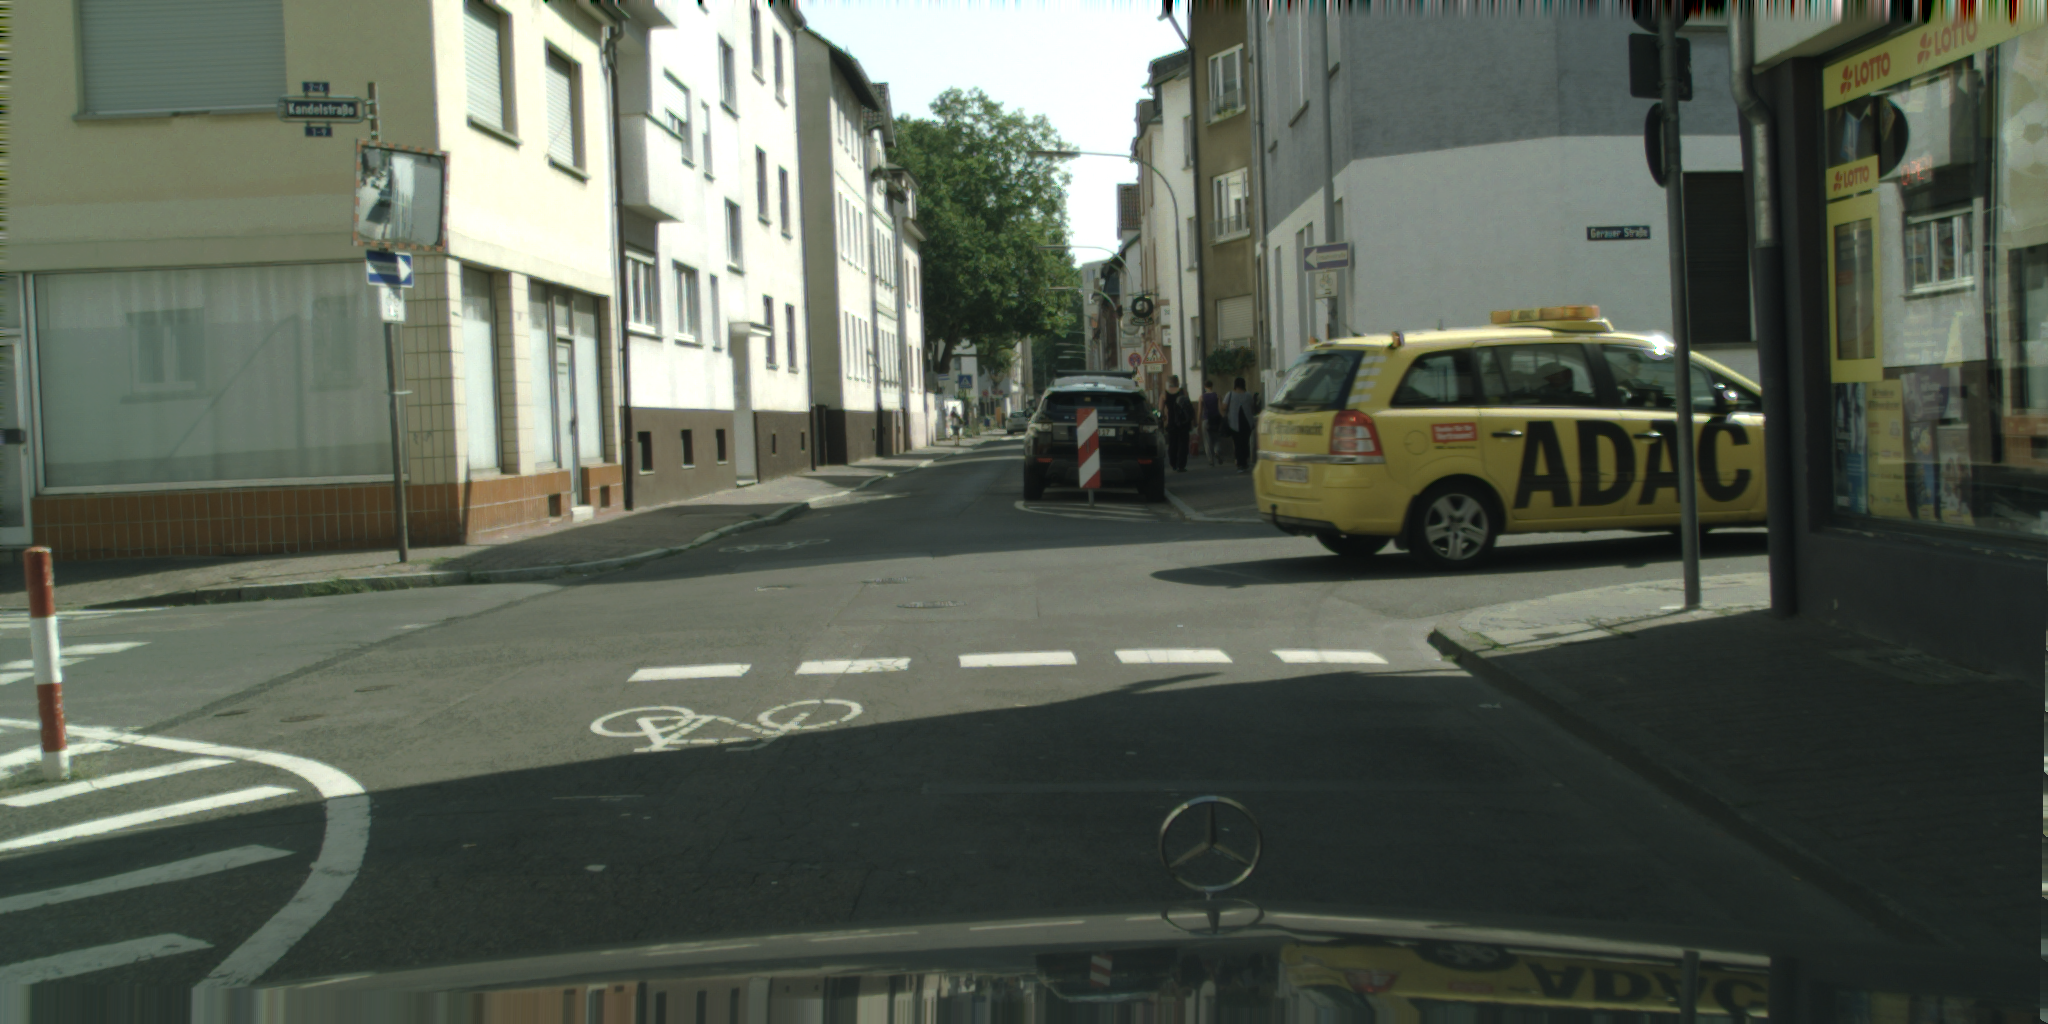

In [37]:
# Load only validation split in streaming mode
dataset = load_dataset(
    "Chris1/cityscapes",
    split="validation",
    streaming=True
)
# Take a single sample
sample = next(iter(dataset))
image = sample["image"].convert("RGB")
image

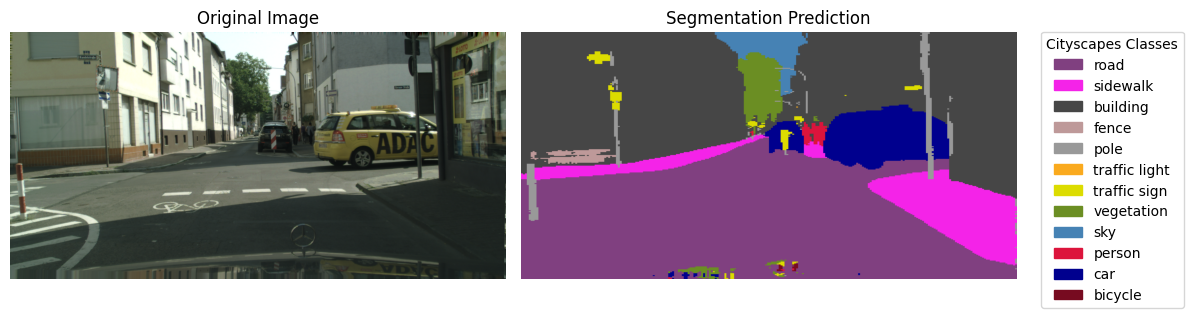

In [40]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Predict segmentation and convert to numpy
pred_mask = outputs.logits.argmax(dim=1)[0].cpu().numpy()

# Resize mask to original image size
mask_img = Image.fromarray(pred_mask.astype(np.uint8))
mask_img = mask_img.resize(image.size, resample=Image.NEAREST)
mask_np = np.array(mask_img)

# Visualize the original image and predicted segmentation results
visualize_segmentation_pair(image, mask_np, show_legend=True)

## Step 2: Pulling SVI of the given region from Google Map through API

In [18]:
import getpass
import os

if not os.getenv("GOOGLEMAP_API_KEY"):
    os.environ["GOOGLEMAP_API_KEY"] = getpass.getpass("Enter your Google Map API key: ")

Enter your Google Map API key:  ········


In [29]:
# Google Maps API settings
API_KEY = os.environ["GOOGLEMAP_API_KEY"] 
BASE_URL = "https://maps.googleapis.com/maps/api/streetview"
META_URL = "https://maps.googleapis.com/maps/api/streetview/metadata"

In [2]:
import requests
from io import BytesIO
import os

# Define a small area (e.g., grid of coordinates within a block)
lat_center, lon_center = 40.748817, -73.985428  # Example: near NYC Empire State
delta = 0.0005  # small offset in degrees (~50m)
coords = [
    (lat_center + dx, lon_center + dy)
    for dx in [-delta, 0, delta]
    for dy in [-delta, 0, delta]
]

# Image output folder
SAVE_DIR = "google_svi/test/images"
os.makedirs(SAVE_DIR, exist_ok=True)

# Function to check if street view is available at a given lat/lon
def is_streetview_available(lat, lon):
    params = {
        "location": f"{lat},{lon}",
        "key": API_KEY
    }
    response = requests.get(META_URL, params=params)
    data = response.json()
    return data.get("status") == "OK" and data.get("pano_id") is not None

# Function to download and save street view image at a given location
def download_streetview_image(lat, lon, heading=0, pitch=0, fov=90, size="640x640", save=True):
    params = {
        "location": f"{lat},{lon}",
        "size": size,
        "heading": heading,
        "pitch": pitch,
        "fov": fov,
        "key": API_KEY
    }
    response = requests.get(BASE_URL, params=params)

    if response.status_code == 200:
        image = Image.open(BytesIO(response.content))
        if save:
            os.makedirs(SAVE_DIR, exist_ok=True)
            filename = f"lat{lat:.6f}_lon{lon:.6f}_hdg{heading}.jpg"
            filepath = os.path.join(SAVE_DIR, filename)
            image.save(filepath)
            print(f"Saved image: {filepath}")
        return image
    else:
        print(f"Failed to download image at ({lat}, {lon})")
        return None
        
# Define a small non-tourist area (Fremont industrial area)
lat_start, lon_start = 37.485, -121.945
delta = 0.002  # ~200 meters step
rows, cols = 4, 5  # 20 images in total

# Download images over the defined grid
image_data = []
for i in range(rows):
    for j in range(cols):
        lat = lat_start + i * delta
        lon = lon_start + j * delta
        if is_streetview_available(lat, lon):
            img = download_streetview_image(lat, lon, heading=0)
            if img:
                image_data.append({"lat": lat, "lon": lon, "image": img})

NameError: name 'API_KEY' is not defined

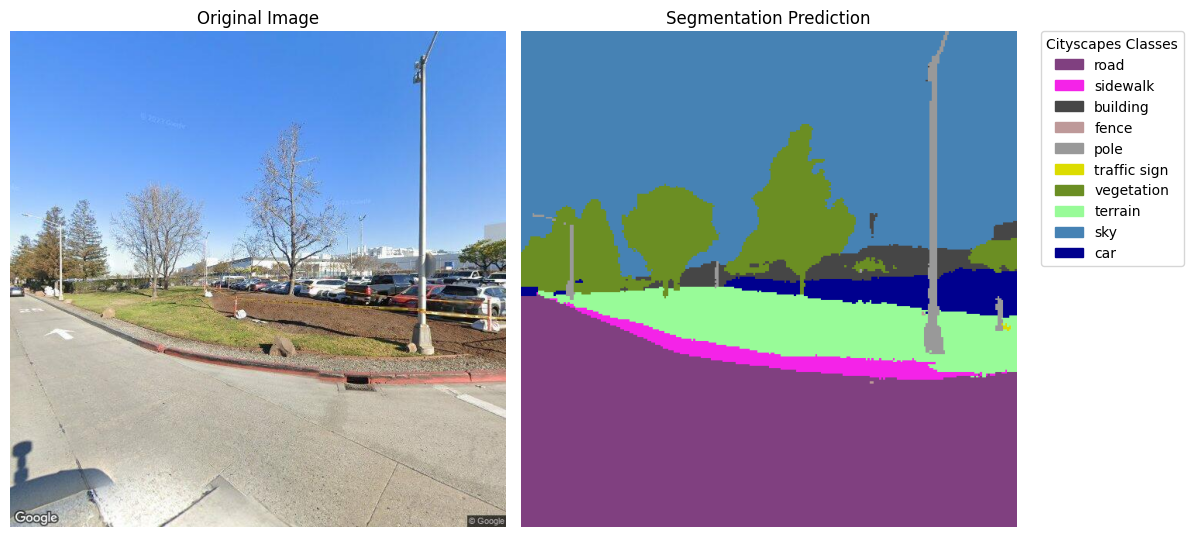

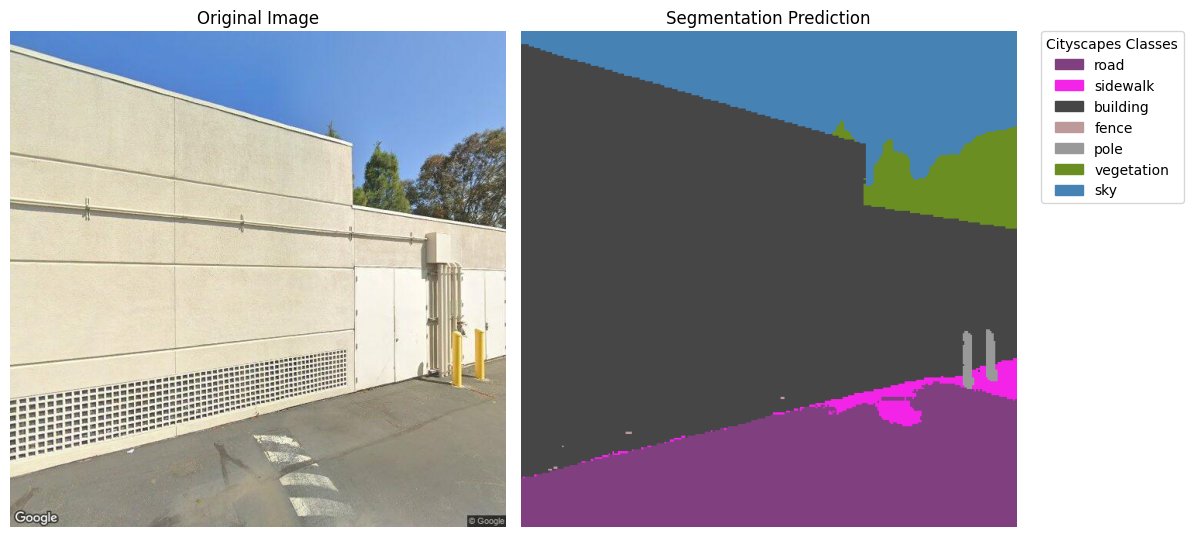

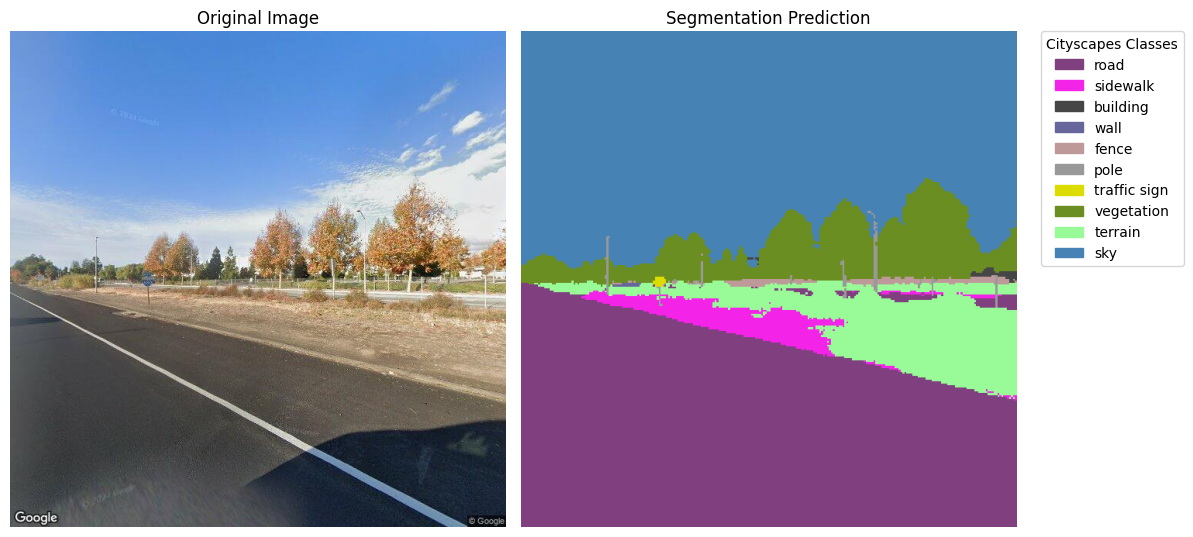

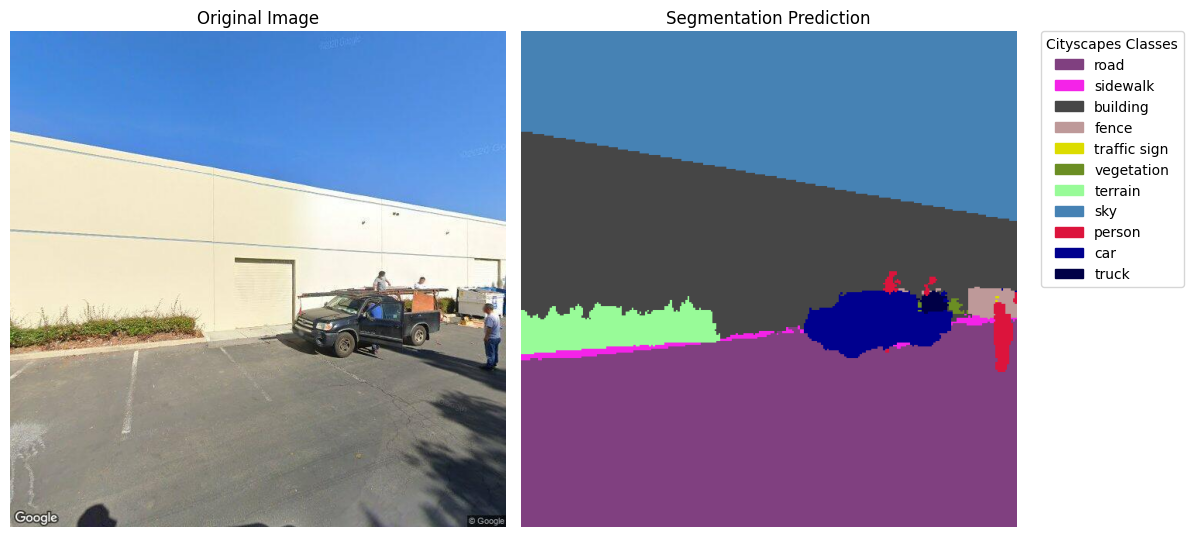

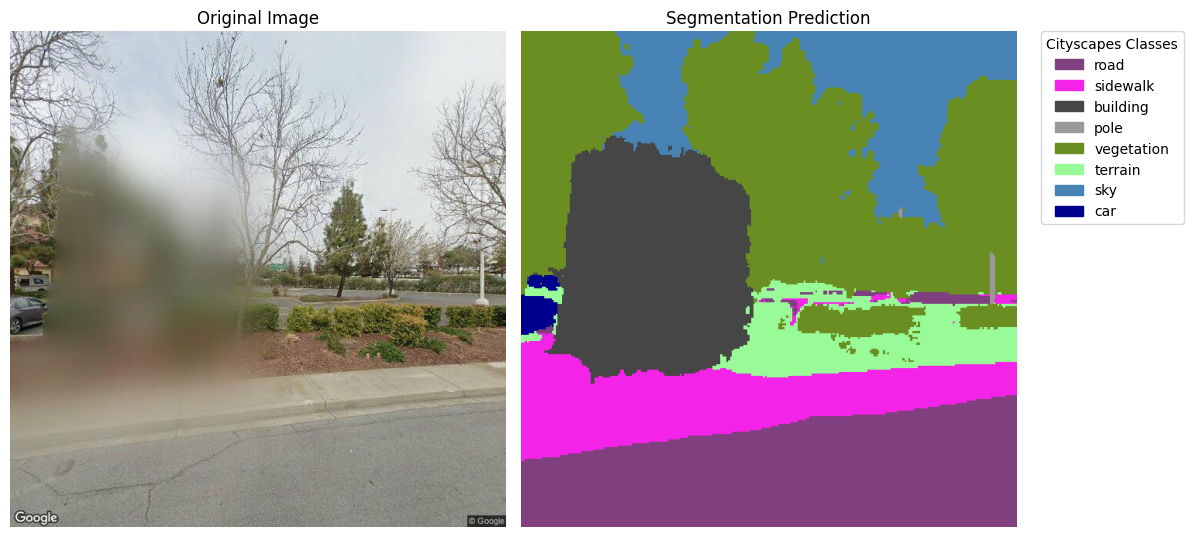

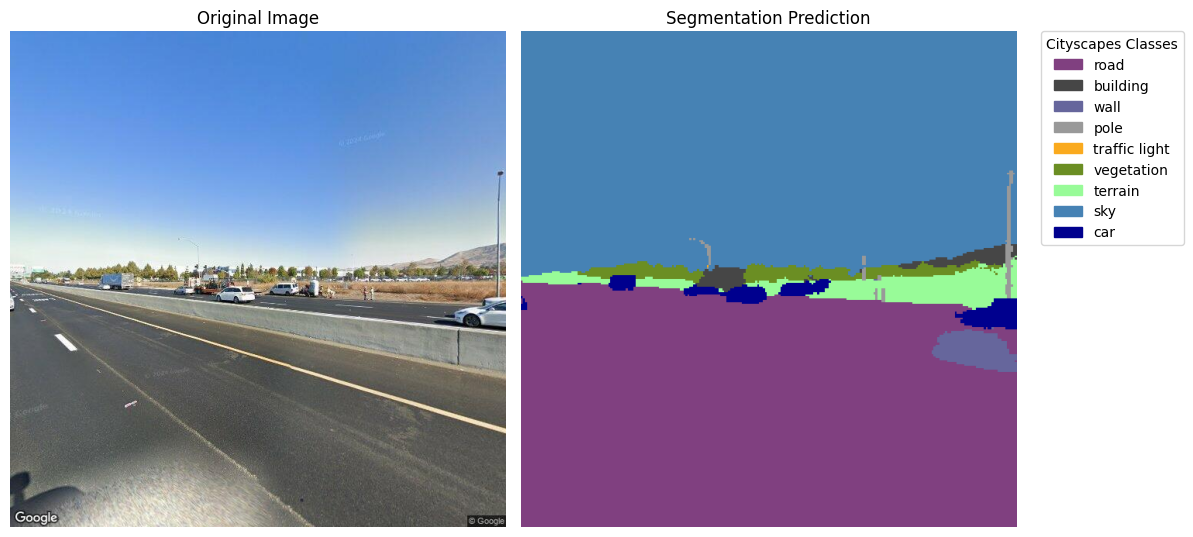

In [47]:
OUTPUT_DIR = "google_svi/test"
os.makedirs(OUTPUT_DIR, exist_ok=True)

image_filenames = [f for f in os.listdir(SAVE_DIR) if f.lower().endswith((".jpg", ".png", ".jpeg"))]

for i, filename in enumerate(image_filenames):
    image_path = os.path.join(SAVE_DIR, filename)
    image_pil = Image.open(image_path).convert("RGB")

    # run segmentation inferences for pulled SVIs
    mask_np = segment_and_save_images(
        image_pil=image_pil,
        processor=processor,
        model=model,
        save_dir=OUTPUT_DIR,
        filename_prefix=os.path.splitext(filename)[0]
    )

    # visualize the first several images
    if i < 6:
        visualize_segmentation_pair(image_pil, mask_np, show_legend=True)